In [59]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# sciKit libraries
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
# import k-means from clustering stage
from sklearn.cluster import KMeans

# import regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import pylab as pl
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker

%matplotlib inline
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line
import folium # map rendering library


In [2]:
# read crime data
cw_data=pd.read_pickle('cw_data.pkl')
cw_data.sort_values(by=['Neighborhood'],inplace=True)
cw_data.head(3)

,Latitude,Longitude,Borough,Neighborhood
14,52.48547,13.31476,Charlottenburg-Wilmersdorf,Barstraße
0,52.53045,13.29610,Charlottenburg-Wilmersdorf,Charlottenburg-Nord
13,52.49644,13.31653,Charlottenburg-Wilmersdorf,Düsseldorfer Straße


In [3]:
# load rental data
sr_data=pd.read_pickle("rentals_cw.pkl")
sr_data.head(3)

,Neighborhood,Rental costs,Borough,Postcode,Longitude,Latitude
0,Charlottenburg,15.61,Charlottenburg-Wilmersdorf,10585,13.30767,52.516531
1,Grunewald,16.53,Charlottenburg-Wilmersdorf,10711,13.26580,52.483379
2,Halensee,14.94,Charlottenburg-Wilmersdorf,10709,13.29569,52.495972


In [4]:
# load school data
sc_data=pd.read_pickle("schools_cw.pkl")
sc_data.head(3)

,Postcode,Grade,Borough,Neighborhood,Longitude,Latitude
0,10589,2.75,Charlottenburg-Wilmersdorf,Charlottenburg-Nord,13.308494,52.529399
1,14193,2.28,Charlottenburg-Wilmersdorf,Schmargendorf,13.290050,52.475800
2,14193,2.51,Charlottenburg-Wilmersdorf,Schmargendorf,13.290050,52.475800


#### Create a column based on the distance to a school

In [5]:
from math import sin, cos, sqrt, atan2, radians

def calculate_distance(x1, y1, x2, y2): # calculate distance from the schools to each Neighborhood
    lat1 = radians(x1)
    lon1 = radians(y1)
    lat2 = radians(x2)
    lon2 = radians(y2)

    # approximate radius of earth in km 
    R = 6373.0
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c

    return distance


In [6]:
# calculate distances to schools for every neighborhood, then threshold based on the distance radius
mySchools=[]
x1=52.529399 # school one
y1=13.308494
x2=52.475800 # school two 
y2=13.290050
for lan,lat in zip(cw_data['Longitude'],cw_data['Latitude']):
    dist1=calculate_distance(lat, lan, x1, y1)
    dist2=calculate_distance(lat, lan, x2, y2)
    dist=min(dist1,dist2)
    mySchools.append(dist)
print(mySchools)

[1.9896928028352823, 0.8467650291555382, 2.91334726755236, 1.8465127920050264, 1.8465127920050264, 2.275798279008654, 3.7664224980112344, 2.6095855612969836, 3.168187038812842, 0.48484618779382094, 3.0585701402674372, 1.4714438690213099, 1.783108688730541, 0.0, 2.5532776394501933, 3.607090946702519, 1.3725503013513376]


In [7]:
# determine the max distamce to a school
maxDist=1.5
weightedSchools=[ 0 if x >= maxDist else 1 for x in mySchools]
print(weightedSchools)

[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1]


#### Create a column based on the average rental costs using kNN method

In [8]:
X = sr_data[['Longitude','Latitude']] .values  #.astype(float)
X[0:5]

array([[13.30766996, 52.51653136],
       [13.2658    , 52.483379  ],
       [13.29569   , 52.495972  ],
       [13.29005   , 52.4758    ],
       [13.25981   , 52.516201  ]])

In [9]:
# contineous 
yc = sr_data['Rental costs'].values
# discrete
y=np.arange(1,7,1)
print(yc,y)

[15.61 16.53 14.94 14.34 13.2  14.71] [1 2 3 4 5 6]


In [10]:
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[ 0.82801329,  1.32551494],
       [-1.12278568, -0.729144  ],
       [ 0.2698448 ,  0.05132298],
       [ 0.00706675, -1.19886205],
       [-1.40187088,  1.30504066]])

In [11]:
# Training model: no evaluation due to the limited amount of data
k = 3 
neigh = KNeighborsClassifier(n_neighbors = k).fit(X,y)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [12]:
# Predict missing rental costs
X_test = cw_data[['Longitude','Latitude']] .values
X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test.astype(float))
yhat = neigh.predict(X_test)
yhat[0:5]

array([3, 1, 3, 2, 2])

In [13]:
weightedRents=yhat/6

#### Prediction of the crime in the corresponding neighborhood

In [14]:
# load crime years data to use in the predictions
pred_data=pd.read_pickle("crimeprediction_cw.pkl")
pred_data.sort_index(axis=0,inplace=True)
pred_data = pred_data.replace(' ','', regex=True)
pred_data=pred_data.astype(float)
pred_data.head()

,Year 2012,Year 2013,Year 2014,Year 2015,Year 2016,Year 2017,Year 2018
Neighborhood,,,,,,,
Barstraße,1634.0,1726.0,1696.0,1732.0,1604.0,1596.0,1634.0
Charlottenburg-Nord,2532.0,2730.0,2913.0,2945.0,3169.0,2846.0,2532.0
Düsseldorfer Straße,4094.0,3855.0,4059.0,4483.0,3961.0,3940.0,4094.0
Forst Grunewald,105.0,147.0,92.0,108.0,131.0,72.0,105.0
Grunewald,1754.0,1667.0,1652.0,1679.0,1630.0,1675.0,1754.0


In [15]:
# apply polynomial regression
X=np.arange(2012,2019,1.0)
X=np.expand_dims(X, axis=1)
train_y =  np.asanyarray(pred_data.loc['Charlottenburg-Nord'].to_list())

In [16]:
# model one degree
poly1 = PolynomialFeatures(degree=1)
train_x_poly1 = poly1.fit_transform(X)
clf1 = linear_model.LinearRegression()
train_y_ = clf1.fit(train_x_poly1, train_y)
# The coefficients
print ('Coefficients: ', clf1.coef_)
print ('Intercept: ',clf1.intercept_)

Coefficients:  [ 0.         17.42857143]
Intercept:  -32308.999999999993


In [17]:
# model 3 degree
poly3 = PolynomialFeatures(degree=3)
train_x_poly3 = poly3.fit_transform(X)
clf3 = linear_model.LinearRegression()
train_y_ = clf3.fit(train_x_poly3, train_y)
# The coefficients
print ('Coefficients: ', clf3.coef_)
print ('Intercept: ',clf3.intercept_)

Coefficients:  [ 0.00000000e+00 -1.25610343e+08  6.23937121e+04 -1.03308091e+01]
Intercept:  84292333054.34557


In [18]:
yy1 = clf1.intercept_ + clf1.coef_[1]*X
yy3 = clf3.intercept_ + clf3.coef_[1]*X + clf3.coef_[2]*np.power(X, 2) + clf3.coef_[3]*np.power(X, 3)

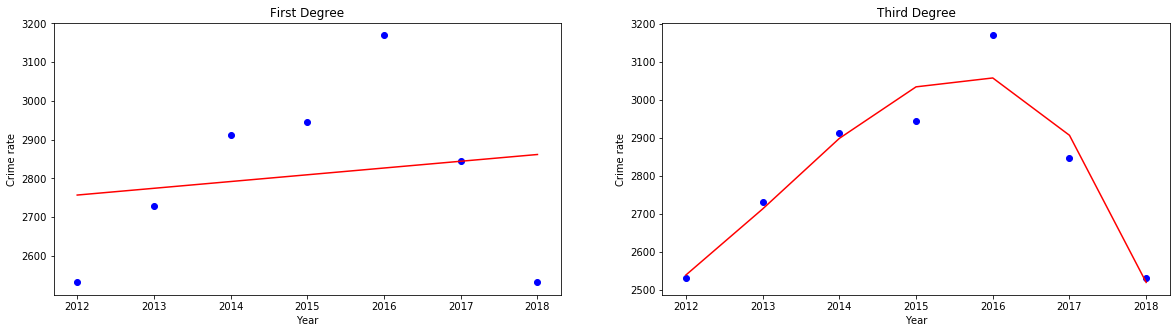

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
ax1.scatter( X,train_y, color='blue')
ax1.plot(X, yy1, '-r' )
ax1.set(xlabel="Year", ylabel="Crime rate")
ax1.title.set_text('First Degree')

ax2.scatter( X,train_y, color='blue')
ax2.plot(X, yy3, '-r' )
ax2.set(xlabel="Year", ylabel="Crime rate") #,fontsize = 20.0)
ax2.title.set_text('Third Degree')
#ax2.xaxis.set_tick_params(labelsize=20)
#Axis.set_label_text(self, label, fontdict=None)

In [20]:
nname=pred_data.index.values.tolist()
#pred_data.reset_index(drop=False, inplace=False)
len(nname)

17

In [21]:
# The better fit is provided by a polinomial of the third degree. However, a trend is better to see by linear regression
train_x=X
myCoeff=[]
for name in nname:
    clf = linear_model.LinearRegression()
    train_y =  np.asanyarray(pred_data.loc[name].to_list())
    train_y_ = clf.fit(train_x, train_y)
    myCoeff.append(clf.coef_[0])
print(nname, myCoeff)

['Barstraße', 'Charlottenburg-Nord', 'Düsseldorfer Straße', 'Forst Grunewald', 'Grunewald', 'Halensee', 'Heerstrasse', 'Kantstraße', 'Kurfürstendamm', 'Mierendorffplatz', 'Neue Kantstraße', 'Otto-Suhr-Allee', 'Schloß Charlottenburg', 'Schmargendorf', 'Volkspark Wilmersdorf', 'Westend', 'Wiesbadener Straße'] [-12.57142857142857, 17.428571428571438, 2.57142857142857, -3.964285714285714, -0.21428571428571508, -19.64285714285714, -4.2857142857142865, -43.857142857142875, -110.32142857142856, 15.64285714285714, 21.678571428571423, -2.5000000000000093, 0.678571428571427, -14.678571428571429, 271.25, 40.21428571428571, -5.82142857142857]


In [22]:
# we wonna have either a negative coef or one with a small positive slope
weightedCrimes=[ 1 if x >= 4 else 0 for x in myCoeff]
weightedCrimes

[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0]

In [23]:
# create one more column based on the total crime rite
def color(elev): 
    if elev in range(0,2000): 
        col = 0
    elif elev in range(2001,3999): 
        col = 1
    elif elev in range(4000,5999): 
        col = 2
    else: 
        col=  3
    return col

weightedRates=[color(x) for x in pred_data['Year 2018'].to_list()]
print(weightedRates)

[0, 1, 2, 0, 0, 1, 0, 2, 3, 0, 1, 2, 1, 0, 3, 1, 0]


#### Explore Neighborhoods in CW: Segmenting

In [24]:
cw_venues=pd.read_pickle('cw_venues.pkl')
cw_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Charlottenburg-Nord,52.53045,13.2961,Ristorante Dante,52.526276,13.297480,Italian Restaurant
1,Charlottenburg-Nord,52.53045,13.2961,Belvedere,52.527567,13.295475,Museum
2,Charlottenburg-Nord,52.53045,13.2961,H Tegeler Weg / S Jungfernheide,52.530291,13.296355,Bus Stop
3,Charlottenburg-Nord,52.53045,13.2961,Curry König,52.530841,13.299841,Fast Food Restaurant
4,Charlottenburg-Nord,52.53045,13.2961,Back Lady,52.530452,13.299959,Bakery


In [25]:
# one hot encoding
cw_onehot = pd.get_dummies(cw_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cw_onehot['Neighborhood'] = cw_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [cw_onehot.columns[-1]] + list(cw_onehot.columns[:-1])
cw_onehot = cw_onehot[fixed_columns]

cw_onehot.head()

,Neighborhood,ATM,Art Museum,Asian Restaurant,Bakery,Bank,Bar,Bavarian Restaurant,Bistro,Boarding House,Bookstore,Boutique,Brasserie,Breakfast Spot,Buffet,Burger Joint,Bus Stop,Butcher,Café,Candy Store,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Flower Shop,Food Truck,French Restaurant,Furniture / Home Store,Gas Station,German Restaurant,Gourmet Shop,Greek Restaurant,Gym,Gym / Fitness Center,Halal Restaurant,Health & Beauty Service,Hookah Bar,Hot Spring,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kids Store,Korean Restaurant,Laser Tag,Lebanese Restaurant,Light Rail Station,Liquor Store,Mattress Store,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Movie Theater,Moving Target,Museum,Noodle House,Opera House,Organic Grocery,Park,Pastry Shop,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Restaurant,Sandwich Place,Scenic Lookout,Schnitzel Restaurant,Seafood Restaurant,Snack Place,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Sports Club,Stadium,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Swabian Restaurant,Szechuan Restaurant,Tapas Restaurant,Taverna,Tennis Court,Thai Restaurant,Toy / Game Store,Trattoria/Osteria,Turkish Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Shop
0,Charlottenburg-Nord,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Charlottenburg-Nord,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Charlottenburg-Nord,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Charlottenburg-Nord,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Charlottenburg-Nord,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [26]:
cw_onehot.shape

(506, 123)

In [27]:
# group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
cw_grouped = cw_onehot.groupby('Neighborhood').mean().reset_index()
cw_grouped.head(3)

,Neighborhood,ATM,Art Museum,Asian Restaurant,Bakery,Bank,Bar,Bavarian Restaurant,Bistro,Boarding House,Bookstore,Boutique,Brasserie,Breakfast Spot,Buffet,Burger Joint,Bus Stop,Butcher,Café,Candy Store,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Flower Shop,Food Truck,French Restaurant,Furniture / Home Store,Gas Station,German Restaurant,Gourmet Shop,Greek Restaurant,Gym,Gym / Fitness Center,Halal Restaurant,Health & Beauty Service,Hookah Bar,Hot Spring,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kids Store,Korean Restaurant,Laser Tag,Lebanese Restaurant,Light Rail Station,Liquor Store,Mattress Store,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Movie Theater,Moving Target,Museum,Noodle House,Opera House,Organic Grocery,Park,Pastry Shop,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Restaurant,Sandwich Place,Scenic Lookout,Schnitzel Restaurant,Seafood Restaurant,Snack Place,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Sports Club,Stadium,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Swabian Restaurant,Szechuan Restaurant,Tapas Restaurant,Taverna,Tennis Court,Thai Restaurant,Toy / Game Store,Trattoria/Osteria,Turkish Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Shop
0,Barstraße,0.0,0.0,0.0,0.062500,0.0,0.000000,0.0625,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0625,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0625,0.0,0.0625,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0625,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0625,0.125000,0.0625,0.0625,0.0625,0.000000,0.062500,0.0625,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,0.0625,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
1,Charlottenburg-Nord,0.0,0.0,0.0,0.166667,0.0,0.000000,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.166667,0.0,0.000000,0.0,0.000000,0.0000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.0000,0.0,0.0,0.000000,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0000,0.000000,0.0000,0.0000,0.0000,0.000000,0.166667,0.0000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.166667,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.166667,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
2,Düsseldorfer Straße,0.0,0.0,0.0,0.055556,0.0,0.037037,0.0000,0.0,0.0,0.0,0.037037,0.0,0.0,0.0,0.0,0.000000,0.0,0.037037,0.0,0.018519,0.0000,0.018519,0.0,0.0,0.0,0.0,0.037037,0.018519,0.0000,0.0,0.0000,0.0,0.0,0.018519,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.037037,0.018519,0.018519,0.0,0.0,0.0,0.018519,0.0,0.0000,0.148148,0.0000,0.0000,0.0000,0.018519,0.055556,0.0000,0.0,0.018519,0.0,0.0,0.0,0.018519,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.018519,0.018519,0.0,0.0,0.0,0.0,0.0,0.018519,0.0,0.0,0.0,0.000000,0.0,0.037037,0.0,0.018519,0.0,0.018519,0.0,0.0,0.0,0.0,0.0,0.0,0.018519,0.018519,0.018519,0.0,0.0,0.0,0.018519,0.018519,0.037037,0.0,0.0,0.018519,0.0,0.0,0.018519,0.0,0.0,0.0,0.055556,0.0,0.018519


In [28]:
cw_grouped.sort_values(by=['Neighborhood'])
cw_grouped.head(3)

,Neighborhood,ATM,Art Museum,Asian Restaurant,Bakery,Bank,Bar,Bavarian Restaurant,Bistro,Boarding House,Bookstore,Boutique,Brasserie,Breakfast Spot,Buffet,Burger Joint,Bus Stop,Butcher,Café,Candy Store,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Flower Shop,Food Truck,French Restaurant,Furniture / Home Store,Gas Station,German Restaurant,Gourmet Shop,Greek Restaurant,Gym,Gym / Fitness Center,Halal Restaurant,Health & Beauty Service,Hookah Bar,Hot Spring,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kids Store,Korean Restaurant,Laser Tag,Lebanese Restaurant,Light Rail Station,Liquor Store,Mattress Store,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Movie Theater,Moving Target,Museum,Noodle House,Opera House,Organic Grocery,Park,Pastry Shop,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Restaurant,Sandwich Place,Scenic Lookout,Schnitzel Restaurant,Seafood Restaurant,Snack Place,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Sports Club,Stadium,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Swabian Restaurant,Szechuan Restaurant,Tapas Restaurant,Taverna,Tennis Court,Thai Restaurant,Toy / Game Store,Trattoria/Osteria,Turkish Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Shop
0,Barstraße,0.0,0.0,0.0,0.062500,0.0,0.000000,0.0625,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0625,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0625,0.0,0.0625,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0625,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0625,0.125000,0.0625,0.0625,0.0625,0.000000,0.062500,0.0625,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,0.0625,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
1,Charlottenburg-Nord,0.0,0.0,0.0,0.166667,0.0,0.000000,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.166667,0.0,0.000000,0.0,0.000000,0.0000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.0000,0.0,0.0,0.000000,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0000,0.000000,0.0000,0.0000,0.0000,0.000000,0.166667,0.0000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.166667,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.166667,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
2,Düsseldorfer Straße,0.0,0.0,0.0,0.055556,0.0,0.037037,0.0000,0.0,0.0,0.0,0.037037,0.0,0.0,0.0,0.0,0.000000,0.0,0.037037,0.0,0.018519,0.0000,0.018519,0.0,0.0,0.0,0.0,0.037037,0.018519,0.0000,0.0,0.0000,0.0,0.0,0.018519,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.037037,0.018519,0.018519,0.0,0.0,0.0,0.018519,0.0,0.0000,0.148148,0.0000,0.0000,0.0000,0.018519,0.055556,0.0000,0.0,0.018519,0.0,0.0,0.0,0.018519,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.018519,0.018519,0.0,0.0,0.0,0.0,0.0,0.018519,0.0,0.0,0.0,0.000000,0.0,0.037037,0.0,0.018519,0.0,0.018519,0.0,0.0,0.0,0.0,0.0,0.0,0.018519,0.018519,0.018519,0.0,0.0,0.0,0.018519,0.018519,0.037037,0.0,0.0,0.018519,0.0,0.0,0.018519,0.0,0.0,0.0,0.055556,0.0,0.018519


In [29]:
cw_grouped['Schools']=weightedSchools
cw_grouped['Crimes'] =weightedRates #weightedCrimes
cw_grouped['Rentals']=weightedRents
cw_grouped.head(3)

,Neighborhood,ATM,Art Museum,Asian Restaurant,Bakery,Bank,Bar,Bavarian Restaurant,Bistro,Boarding House,Bookstore,Boutique,Brasserie,Breakfast Spot,Buffet,Burger Joint,Bus Stop,Butcher,Café,Candy Store,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Flower Shop,Food Truck,French Restaurant,Furniture / Home Store,Gas Station,German Restaurant,Gourmet Shop,Greek Restaurant,Gym,Gym / Fitness Center,Halal Restaurant,Health & Beauty Service,Hookah Bar,Hot Spring,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kids Store,Korean Restaurant,Laser Tag,Lebanese Restaurant,Light Rail Station,Liquor Store,Mattress Store,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Movie Theater,Moving Target,Museum,Noodle House,Opera House,Organic Grocery,Park,Pastry Shop,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Restaurant,Sandwich Place,Scenic Lookout,Schnitzel Restaurant,Seafood Restaurant,Snack Place,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Sports Club,Stadium,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Swabian Restaurant,Szechuan Restaurant,Tapas Restaurant,Taverna,Tennis Court,Thai Restaurant,Toy / Game Store,Trattoria/Osteria,Turkish Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Shop,Schools,Crimes,Rentals
0,Barstraße,0.0,0.0,0.0,0.062500,0.0,0.000000,0.0625,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0625,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0625,0.0,0.0625,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0625,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0625,0.125000,0.0625,0.0625,0.0625,0.000000,0.062500,0.0625,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,0.0625,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0,0,0.500000
1,Charlottenburg-Nord,0.0,0.0,0.0,0.166667,0.0,0.000000,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.166667,0.0,0.000000,0.0,0.000000,0.0000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.0000,0.0,0.0,0.000000,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0000,0.000000,0.0000,0.0000,0.0000,0.000000,0.166667,0.0000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.166667,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.166667,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,1,1,0.166667
2,Düsseldorfer Straße,0.0,0.0,0.0,0.055556,0.0,0.037037,0.0000,0.0,0.0,0.0,0.037037,0.0,0.0,0.0,0.0,0.000000,0.0,0.037037,0.0,0.018519,0.0000,0.018519,0.0,0.0,0.0,0.0,0.037037,0.018519,0.0000,0.0,0.0000,0.0,0.0,0.018519,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.037037,0.018519,0.018519,0.0,0.0,0.0,0.018519,0.0,0.0000,0.148148,0.0000,0.0000,0.0000,0.018519,0.055556,0.0000,0.0,0.018519,0.0,0.0,0.0,0.018519,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.018519,0.018519,0.0,0.0,0.0,0.0,0.0,0.018519,0.0,0.0,0.0,0.000000,0.0,0.037037,0.0,0.018519,0.0,0.018519,0.0,0.0,0.0,0.0,0.0,0.0,0.018519,0.018519,0.018519,0.0,0.0,0.0,0.018519,0.018519,0.037037,0.0,0.0,0.018519,0.0,0.0,0.018519,0.0,0.0,0.0,0.055556,0.0,0.018519,0,2,0.500000


In [30]:
# print each neighborhood along with the top 2 most common venues
num_top_venues = 2
for hood in cw_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = cw_grouped[cw_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Barstraße----
     venue  freq
0  Rentals  0.50
1    Hotel  0.12


----Charlottenburg-Nord----
     venue  freq
0   Crimes   1.0
1  Schools   1.0


----Düsseldorfer Straße----
     venue  freq
0   Crimes   2.0
1  Rentals   0.5


----Forst Grunewald----
                venue  freq
0             Rentals  0.33
1  Italian Restaurant  0.20


----Grunewald----
                venue  freq
0             Rentals  0.33
1  Italian Restaurant  0.20


----Halensee----
     venue  freq
0   Crimes  1.00
1  Rentals  0.33


----Heerstrasse----
          venue  freq
0       Rentals  0.33
1  Tennis Court  0.12


----Kantstraße----
     venue  freq
0   Crimes  2.00
1  Rentals  0.17


----Kurfürstendamm----
     venue  freq
0   Crimes  3.00
1  Rentals  0.17


----Mierendorffplatz----
     venue  freq
0  Schools  1.00
1  Rentals  0.17


----Neue Kantstraße----
     venue  freq
0   Crimes  1.00
1  Rentals  0.33


----Otto-Suhr-Allee----
     venue  freq
0   Crimes   2.0
1  Schools   1.0


----Schloß Char

In [31]:
# put that into a pandas dataframe
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [60]:
# create the new dataframe and display the top 5 venues for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = cw_grouped['Neighborhood']

for ind in np.arange(cw_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cw_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barstraße,Rentals,Hotel,Climbing Gym,Japanese Restaurant,Italian Restaurant,Indie Movie Theater,Indian Restaurant,Mexican Restaurant,Ice Cream Shop,Moving Target
1,Charlottenburg-Nord,Schools,Crimes,Rentals,Platform,Bakery,Italian Restaurant,Bus Stop,Fast Food Restaurant,Museum,Furniture / Home Store
2,Düsseldorfer Straße,Crimes,Rentals,Hotel,Vietnamese Restaurant,Bakery,Italian Restaurant,Plaza,German Restaurant,Café,Bar
3,Forst Grunewald,Rentals,Italian Restaurant,Hotel,German Restaurant,Sports Club,Café,Supermarket,Bus Stop,Plaza,Bakery
4,Grunewald,Rentals,Italian Restaurant,Hotel,German Restaurant,Sports Club,Café,Supermarket,Bus Stop,Plaza,Bakery


#### Explore Neighborhoods in CW: Clustering

In [61]:
# set number of clusters
kclusters = 5

cw_grouped_clustering = cw_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cw_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 4, 1, 3, 3, 0, 3, 1, 1, 2], dtype=int32)

In [62]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_) #uncomment if exist
neighborhoods_venues_sorted['Cluster Labels']= kmeans.labels_

cw_merged = cw_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
cw_merged = cw_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

cw_merged.head() # check the last columns!

,Latitude,Longitude,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,52.48547,13.31476,Charlottenburg-Wilmersdorf,Barstraße,3,Rentals,Hotel,Climbing Gym,Japanese Restaurant,Italian Restaurant,Indie Movie Theater,Indian Restaurant,Mexican Restaurant,Ice Cream Shop,Moving Target
0,52.53045,13.29610,Charlottenburg-Wilmersdorf,Charlottenburg-Nord,4,Schools,Crimes,Rentals,Platform,Bakery,Italian Restaurant,Bus Stop,Fast Food Restaurant,Museum,Furniture / Home Store
13,52.49644,13.31653,Charlottenburg-Wilmersdorf,Düsseldorfer Straße,1,Crimes,Rentals,Hotel,Vietnamese Restaurant,Bakery,Italian Restaurant,Plaza,German Restaurant,Café,Bar
16,52.48338,13.26580,Charlottenburg-Wilmersdorf,Forst Grunewald,3,Rentals,Italian Restaurant,Hotel,German Restaurant,Sports Club,Café,Supermarket,Bus Stop,Plaza,Bakery
10,52.48338,13.26580,Charlottenburg-Wilmersdorf,Grunewald,3,Rentals,Italian Restaurant,Hotel,German Restaurant,Sports Club,Café,Supermarket,Bus Stop,Plaza,Bakery


In [63]:
# create map
# coordinates of Charlottenburg-Wilmersdorf
latitude  = 52.500000  # neighborhood latitude value
longitude = 13.283333 # neighborhood longitude valu
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cw_merged['Latitude'], cw_merged['Longitude'], cw_merged['Neighborhood'], cw_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Examine Clusters

In [36]:
# cluster 1
cw_merged.loc[cw_merged['Cluster Labels'] == 0, \
               cw_merged.columns[[1] + list(range(5, cw_merged.shape[1]))]]

,Longitude,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
9,13.29569,Rentals,Supermarket,Drugstore,Italian Restaurant,Café,Plaza,Japanese Restaurant,German Restaurant,Greek Restaurant,0
6,13.28370,Rentals,Hotel,Asian Restaurant,Mexican Restaurant,Doner Restaurant,Boarding House,Café,Italian Restaurant,Park,0
3,13.29639,Rentals,Café,Art Museum,Trattoria/Osteria,Ice Cream Shop,German Restaurant,Taverna,Italian Restaurant,Bakery,0
2,13.25981,Rentals,Café,Park,Bus Stop,Bakery,Italian Restaurant,Plaza,Drugstore,Thai Restaurant,0


In [37]:
# cluster 2
cw_merged.loc[cw_merged['Cluster Labels'] == 1, \
               cw_merged.columns[[1] + list(range(5, cw_merged.shape[1]))]]

,Longitude,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
13,13.31653,Rentals,Hotel,Vietnamese Restaurant,Bakery,Italian Restaurant,Plaza,German Restaurant,Café,Bar,1
7,13.31435,Rentals,German Restaurant,Vietnamese Restaurant,Italian Restaurant,Asian Restaurant,Korean Restaurant,Chinese Restaurant,Doner Restaurant,Restaurant,1
8,13.31891,Rentals,Hotel,Italian Restaurant,German Restaurant,Café,Boutique,Bookstore,Vietnamese Restaurant,Dessert Shop,1
15,13.32595,Rentals,Bakery,Supermarket,Bus Stop,Vietnamese Restaurant,Indie Movie Theater,Plaza,Mexican Restaurant,Greek Restaurant,1


#### Hierarchical Clustering - Agglomerative

In [38]:
from scipy import ndimage 
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix
from sklearn import manifold, datasets 
from sklearn.cluster import AgglomerativeClustering 

In [39]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
feature_mtx = min_max_scaler.fit_transform(cw_grouped_clustering)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [40]:
dist_matrix = distance_matrix(feature_mtx,feature_mtx) 
dist_matrix[0:3]

array([[0.        , 4.12777654, 5.30331733, 3.83593055, 3.83593055,
        4.3603775 , 4.03331428, 5.52198823, 5.3869233 , 4.50552345,
        4.25939157, 4.51701269, 4.61696059, 4.1439143 , 4.38506652,
        4.0573521 , 4.30100386],
       [4.12777654, 0.        , 5.11138532, 3.01907349, 3.01907349,
        4.44921539, 3.38809491, 5.22129189, 5.05451685, 3.86803209,
        4.29715284, 3.69015087, 4.13830151, 3.60487536, 4.20092169,
        3.47220139, 3.68219264],
       [5.30331733, 5.11138532, 0.        , 4.68502777, 4.68502777,
        5.24207738, 5.10933831, 5.47874212, 4.43716202, 5.27590833,
        4.96805119, 5.08120821, 5.33993015, 5.37294469, 5.21341952,
        4.84351034, 5.26299838]])

In [47]:
n_clusters = 5
agglom = AgglomerativeClustering(n_clusters = n_clusters, linkage = 'complete')
agglom.fit(feature_mtx)
agglom.labels_

array([0, 0, 2, 0, 0, 1, 0, 3, 2, 0, 0, 0, 1, 0, 4, 0, 0])

In [65]:
# add clustering labels
neighborhoods_venues_sorted['Cluster Labels']=agglom.labels_
cw_merged = cw_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
cw_merged = cw_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

cw_merged.head() # check the last columns!

,Latitude,Longitude,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,52.48547,13.31476,Charlottenburg-Wilmersdorf,Barstraße,0,Rentals,Hotel,Climbing Gym,Japanese Restaurant,Italian Restaurant,Indie Movie Theater,Indian Restaurant,Mexican Restaurant,Ice Cream Shop,Moving Target
0,52.53045,13.29610,Charlottenburg-Wilmersdorf,Charlottenburg-Nord,0,Schools,Crimes,Rentals,Platform,Bakery,Italian Restaurant,Bus Stop,Fast Food Restaurant,Museum,Furniture / Home Store
13,52.49644,13.31653,Charlottenburg-Wilmersdorf,Düsseldorfer Straße,2,Crimes,Rentals,Hotel,Vietnamese Restaurant,Bakery,Italian Restaurant,Plaza,German Restaurant,Café,Bar
16,52.48338,13.26580,Charlottenburg-Wilmersdorf,Forst Grunewald,0,Rentals,Italian Restaurant,Hotel,German Restaurant,Sports Club,Café,Supermarket,Bus Stop,Plaza,Bakery
10,52.48338,13.26580,Charlottenburg-Wilmersdorf,Grunewald,0,Rentals,Italian Restaurant,Hotel,German Restaurant,Sports Club,Café,Supermarket,Bus Stop,Plaza,Bakery


In [66]:
# create map
# coordinates of Charlottenburg-Wilmersdorf
latitude  = 52.500000  # neighborhood latitude value
longitude = 13.283333 # neighborhood longitude valu
map_clusters2 = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(n_clusters)
ys = [i + x + (i*x)**2 for i in range(n_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cw_merged['Latitude'], cw_merged['Longitude'], cw_merged['Neighborhood'], cw_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)
       
map_clusters2